In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
from Bio import SeqIO
import RNA
import numpy as np
import pandas as pd
import seaborn as sns
import pybedtools
import pybedtools.featurefuncs as featurefuncs
import researchpy as rp
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Importing data:
clustered_df = pd.read_pickle("data/iap_clustered.pkl")
iap_bed = pybedtools.BedTool("data/clean_beds/mm10.IAP.mended.extent.bed")

In [3]:
# Retrieving sequence windows around each IAP:
interval_center = iap_bed.each(
        featurefuncs.center, width=10).saveas()
center_slop = interval_center.slop(b=1000, genome="mm10")
fasta = "data/GRCm38.p6.genome.fa"
center_slop = center_slop.sequence(fi=fasta)

In [4]:
center_slop.save_seqs("data/iap_seq_windows.fa")

<BedTool(/var/folders/6m/_grwz6z90_b14fdyzyd4jfdw0000gn/T/pybedtools.lfst1iu8.tmp)>

In [5]:
slop_df = center_slop.to_dataframe()

In [6]:
with open('data/iap_seq_windows.fa') as fasta_file:  # Will close handle cleanly
    id_array = []
    mfe_array = []
    i = 0
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        id_array.append(seq_record.id)
        fold_compound = RNA.fold_compound(str(seq_record.seq))
        mfe_array.append(fold_compound.mfe_dimer()[1])
        i += 1
        if i % 100 == 0:
            print(str(i) + " sequences processed.")

100 sequences processed.
200 sequences processed.
300 sequences processed.
400 sequences processed.
500 sequences processed.
600 sequences processed.
700 sequences processed.
800 sequences processed.
900 sequences processed.
1000 sequences processed.
1100 sequences processed.
1200 sequences processed.
1300 sequences processed.
1400 sequences processed.
1500 sequences processed.
1600 sequences processed.
1700 sequences processed.
1800 sequences processed.
1900 sequences processed.
2000 sequences processed.
2100 sequences processed.
2200 sequences processed.
2300 sequences processed.
2400 sequences processed.
2500 sequences processed.
2600 sequences processed.
2700 sequences processed.
2800 sequences processed.
2900 sequences processed.
3000 sequences processed.
3100 sequences processed.
3200 sequences processed.
3300 sequences processed.
3400 sequences processed.
3500 sequences processed.
3600 sequences processed.
3700 sequences processed.
3800 sequences processed.
3900 sequences proces

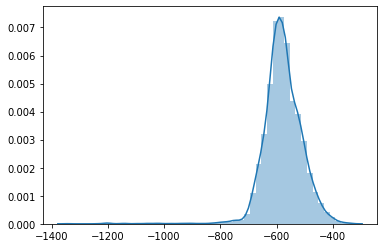

In [7]:
sns.distplot(mfe_array)

In [8]:
mfe_df = pd.DataFrame(columns=["seqID", "mfe"])
mfe_df["seqID"] = id_array
mfe_df["mfe"] = mfe_array
slop_df

,chrom,start,end,name,score,strand
0,chr1,95056305,95058315,151177,33,-
1,chr1,20054348,20056358,25136,37,-
2,chr1,100566711,100568721,159399,47,+
3,chr1,100930383,100932393,160006,50,+
4,chr1,60585664,60587674,91370,51,-
...,...,...,...,...,...,...
8054,chr9,92737376,92739386,4180871,7434,-
8055,chr9,19765898,19767908,4041241,7589,-
8056,chr9,36160263,36162273,4069873,8196,+
8057,chr9,19900815,19902825,4041384,9508,+


In [9]:
mfe_df.index = slop_df["name"].astype(int).to_list()

In [10]:
clustered_df

,chrom,start,end,element_id,length,strand,val_result,cluster_assignments
151177,chr1,95057294,95057326,151177,33,-,Untested,B
25136,chr1,20055335,20055371,25136,37,-,Untested,B
159399,chr1,100567693,100567739,159399,47,+,Untested,A
160006,chr1,100931364,100931413,160006,50,+,Untested,A
91370,chr1,60586644,60586694,91370,51,-,Untested,B
...,...,...,...,...,...,...,...,...
4180871,chr9,92734665,92742098,4180871,7434,-,Untested,C
4041241,chr9,19763109,19770697,4041241,7589,-,Untested,A
4069873,chr9,36157171,36165366,4069873,8196,+,Untested,A
4041384,chr9,19897067,19906574,4041384,9508,+,Untested,A


In [11]:
clustered_df["mfe"] = mfe_df["mfe"]

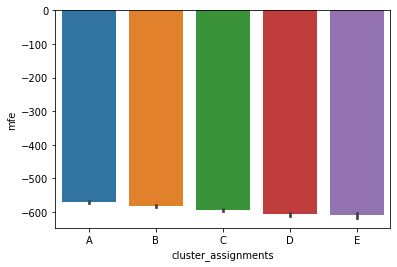

In [15]:
label_order = ["A", "B", "C", "D", "E"]
sns.barplot(x="cluster_assignments", y="mfe", order=label_order, data=clustered_df)

In [18]:
rp.summary_cont(clustered_df['mfe'].groupby(clustered_df['cluster_assignments']))

,N,Mean,SD,SE,95% Conf.,Interval
cluster_assignments,,,,,,
A,4684,-569.694669,73.727955,1.077268,-571.806340,-567.582999
B,1813,-580.817684,64.848573,1.523006,-583.803599,-577.831769
C,942,-593.333471,56.587237,1.843712,-596.949066,-589.717876
D,453,-606.586225,59.199221,2.781422,-612.043839,-601.128610
E,167,-608.516885,48.531668,3.755493,-615.899790,-601.133981


In [27]:
clustered_df['mfe'].groupby(clustered_df['cluster_assignments']).mean()

cluster_assignments
A   -569.694669
B   -580.817684
C   -593.333471
D   -606.586225
E   -608.516885
Name: mfe, dtype: float64

In [21]:
stats.f_oneway(clustered_df['mfe'][clustered_df['cluster_assignments'] == 'A'], 
               clustered_df['mfe'][clustered_df['cluster_assignments'] == 'B'],
               clustered_df['mfe'][clustered_df['cluster_assignments'] == 'C'],
               clustered_df['mfe'][clustered_df['cluster_assignments'] == 'D'],
               clustered_df['mfe'][clustered_df['cluster_assignments'] == 'E'])

F_onewayResult(statistic=57.36518421912151, pvalue=8.340223747789672e-48)

In [22]:
stats.levene(clustered_df['mfe'][clustered_df['cluster_assignments'] == 'A'], 
             clustered_df['mfe'][clustered_df['cluster_assignments'] == 'B'],
             clustered_df['mfe'][clustered_df['cluster_assignments'] == 'C'],
             clustered_df['mfe'][clustered_df['cluster_assignments'] == 'D'],
             clustered_df['mfe'][clustered_df['cluster_assignments'] == 'E'])

LeveneResult(statistic=20.235334277321716, pvalue=1.333665732813831e-16)

In [23]:
stats.ttest_ind(clustered_df['mfe'][clustered_df['cluster_assignments'] == 'A'],
                clustered_df['mfe'][clustered_df['cluster_assignments'] == 'B'])

Ttest_indResult(statistic=5.63516533126062, pvalue=1.8222746287599643e-08)

In [28]:
stats.ttest_ind(clustered_df['mfe'][clustered_df['cluster_assignments'] == 'A'],
                clustered_df['mfe'][clustered_df['cluster_assignments'] == 'C'])

Ttest_indResult(statistic=9.304548570035902, pvalue=1.8856174693667213e-20)

In [29]:
stats.ttest_ind(clustered_df['mfe'][clustered_df['cluster_assignments'] == 'B'],
                clustered_df['mfe'][clustered_df['cluster_assignments'] == 'C'])

Ttest_indResult(statistic=5.014083514181018, pvalue=5.666844457630667e-07)

In [14]:
clustered_df

,chrom,start,end,element_id,length,strand,val_result,cluster_assignments,mfe
151177,chr1,95057294,95057326,151177,33,-,Untested,B,-439.600006
25136,chr1,20055335,20055371,25136,37,-,Untested,B,-471.799988
159399,chr1,100567693,100567739,159399,47,+,Untested,A,-425.100006
160006,chr1,100931364,100931413,160006,50,+,Untested,A,-467.700012
91370,chr1,60586644,60586694,91370,51,-,Untested,B,-517.200012
...,...,...,...,...,...,...,...,...,...
4180871,chr9,92734665,92742098,4180871,7434,-,Untested,C,-609.799988
4041241,chr9,19763109,19770697,4041241,7589,-,Untested,A,-586.099976
4069873,chr9,36157171,36165366,4069873,8196,+,Untested,A,-534.599976
4041384,chr9,19897067,19906574,4041384,9508,+,Untested,A,-640.599976
